# Modelos: Seq

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../lib')
import os

import math
import random
from bunch import Bunch
import seaborn as sns
import numpy   as np
import pandas  as pd

import torch
from   torch               import nn, Tensor
import torch.nn.functional as F
from   torch.utils.data    import DataLoader, Subset
from   torch.optim         import SparseAdam, Adam

import pytorch_common.util as pu
from   pytorch_common.modules.fn import Fn
from   pytorch_common.callbacks  import (
    EarlyStop,
    ReduceLROnPlateau,
    Validation,
    SaveBestModel
)
from pytorch_common.callbacks.output import Logger, MetricsPlotter
from pytorch_common.util import (
    set_device_name,
    get_device,
    LoggerBuilder
)

import model as ml
import util  as ut

import data.dataset as ds
import data.plot    as pl
import data         as dt
from data.plot import describe_num_var

import metric             as mt
import metric.discretizer as dr

import torch.multiprocessing

## Setup

In [4]:
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')

In [7]:
pu.get_device()

device(type='cuda', index=0)

In [8]:
CPU = torch.device('cpu')

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.__version__

'1.13.1+cu117'

In [11]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [12]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [13]:
set_seed(42)

In [14]:
DATASETS_PATH = '../datasets'

In [15]:
class AccFn(torch.nn.Module):
    def __init__(self, device = CPU):
        super().__init__()
        self.model_type = 'AccFn'
        self.device     = device

    def forward(self, y_pred, y_true):
        y_pred_probs  = F.softmax(y_pred, dim=1)
        y_pred_values = torch.argmax(y_pred, axis=1).abs().to(self.device)
        y_true_values = y_true.to(self.device)

        tp = (y_pred_values == y_true_values).sum().item()

        return tp / y_true_values.size(0)

In [16]:
y_pred = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.1, 0.0, 1.0],
])
y_true = torch.tensor([0, 1, 0])

AccFn()(y_pred, y_true)

0.6666666666666666

In [17]:
import torch
import torch.nn.functional as F
import pytorch_common.util as ut

class CrossEntropyLossFn(torch.nn.Module):
    def __init__(self, device = CPU):
        super().__init__()
        self.model_type = 'CrossEntropyLossFn'
        self.loss       = torch.nn.CrossEntropyLoss().to(device)
        self.device     = device

    def forward(self, y_pred, y_true):
        return self.loss(
            y_pred.to(self.device),
            y_true.type(torch.LongTensor).to(self.device)
        )

In [18]:
y_pred = torch.tensor([
    [20.0, 0.0, 20.0], 
    [20.0, 0.0, 20.0], 
    [20.0, 0.0, 20.0]
])
y_true = torch.tensor([0, 1, 2])

CrossEntropyLossFn()(y_pred, y_true)

tensor(7.3598)

## Carga de dataset

In [20]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = CPU,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 1990) & (df['user_movie_rating_year'] <= 2019)]
)

In [21]:
train_set, eval_set = dataset.split_train_eval(split_year=2017)

2023-02-17 12:33:55,124 - INFO - Train: 74.85 % - Test: 8.66 %


In [23]:
def find_movies_count_by_user(df):
    return pd.DataFrame({
       'n_movies': [movie_ids.shape[0] for movie_ids in df.groupby(['user_id']).groups.values()]
    })

df = find_movies_count_by_user(train_set.data)

In [24]:
min_bound, max_bound = dt.n_iqr_range(df, 'n_movies')
min_bound, max_bound

(0, 16.0)

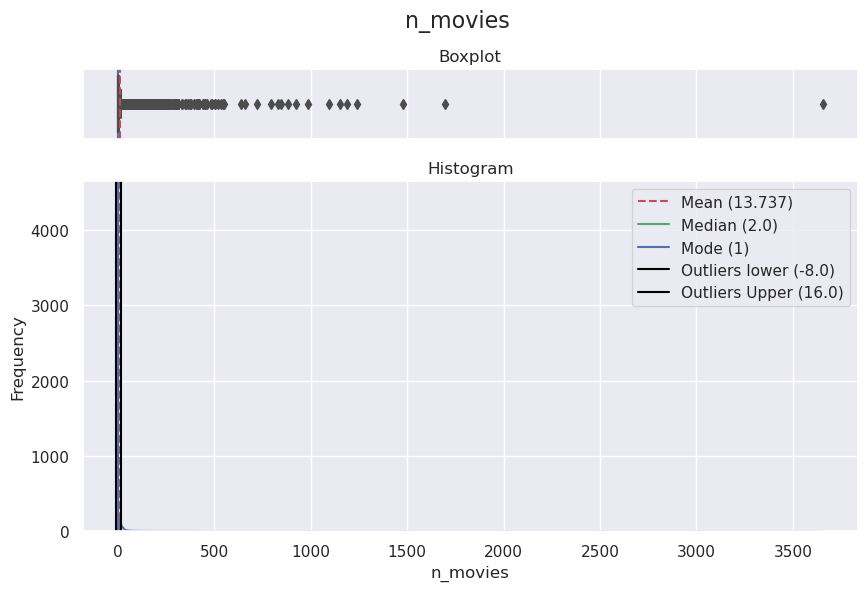

In [25]:
describe_num_var(df, 'n_movies')

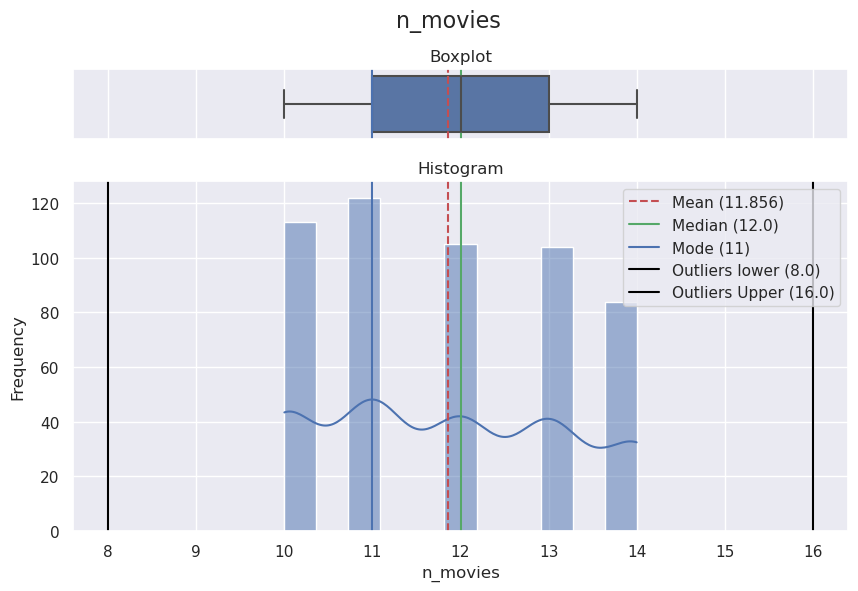

In [31]:
min_input_sequence_dim = 5
max_input_sequence_dim = 15

df = df[(df['n_movies'] >= min_input_sequence_dim) & (df['n_movies'] < max_input_sequence_dim)]

describe_num_var(df, 'n_movies')

In [33]:
n_movies = train_set.data['movie_id'].unique().shape[0]
print(n_movies)

15176

In [34]:
params = Bunch(
    epochs               = 60,
    feat_seq_len         = min_input_sequence_dim,
    max_input_seq_len    = max_input_sequence_dim,
    id_seq_init          = 0,
    train_batch_size     = 512,
    eval_batch_size      = 16,
    n_workers            = 8,
    n_heads              = 5,
    hidden_state_size    = 64,
    n_transformer_layers = 2,
    dropout              = 0.2,
    lr                   = 0.001,
    embedding_dim        = 50,
    vocab_size           = n_movies + 1,
    n_classes            = n_movies,
    mask                 = n_movies
)

In [42]:
train_set.data['timestamp'] = train_set.data['user_movie_rating_timestamp']
eval_set.data['timestamp']  = eval_set.data['user_movie_rating_timestamp']

In [43]:
try:
    train_ds = ds.SequenceDataset.load(f'{DATASETS_PATH}/train')
except:
    train_ds = ds.MovieSequenceDatasetFactory.create(
        train_set.data,
        feat_seq_len      = params.feat_seq_len,
        id_seq_init       = params.id_seq_init,
        max_movie_seq_len = params.max_input_seq_len,
        mask              = params.mask
    )
    train_ds.save(f'{DATASETS_PATH}/train')
    
try:
    eval_ds = ds.SequenceDataset.load(f'{DATASETS_PATH}/eval')
except:
    eval_ds = ds.MovieSequenceDatasetFactory.create(
        eval_set.data,
        feat_seq_len      = params.feat_seq_len,
        id_seq_init       = params.id_seq_init,
        max_movie_seq_len = params.max_input_seq_len,
        train_ds          = train_ds,
        mask              = params.mask
    )
    eval_ds.save(f'{DATASETS_PATH}/eval')


train_dl = DataLoader(
    train_ds,
    params.train_batch_size,
    num_workers     = params.n_workers,
    pin_memory      = True,
    shuffle         = True
)
eval_dl  = DataLoader(
    eval_ds,
    params.eval_batch_size,
    num_workers     = params.n_workers,
    pin_memory      = False,
    shuffle         = True,
    prefetch_factor = 1
)

2023-02-17 13:23:38,977 - INFO - group movies by user id
2023-02-17 13:23:38,978 - INFO - get ordered user movie sequences <= 15


Get user movie sequences:   0%|          | 0/149546 [00:00<?, ?it/s]

2023-02-17 13:25:06,499 - INFO - chunk movie sequences with size=5


Filter complete padded:   0%|          | 0/7865 [00:00<?, ?it/s]

2023-02-17 13:25:06,762 - INFO - group movies by user id
2023-02-17 13:25:06,763 - INFO - get ordered user movie sequences <= 15


Get user movie sequences:   0%|          | 0/17300 [00:00<?, ?it/s]

2023-02-17 13:25:14,748 - INFO - chunk movie sequences with size=5


Filter complete padded:   0%|          | 0/999 [00:00<?, ?it/s]

Filter target that not in train:   0%|          | 0/999 [00:00<?, ?it/s]

2023-02-17 13:25:14,847 - INFO - targets not in train set: 313


## Model Definition

In [44]:
model = ml.TransformerClasifier(
    embedding_dim        = params.embedding_dim,
    vocab_size           = params.vocab_size,
    sequence_size        = params.feat_seq_len,
    mask_position        = params.mask,
    nhead                = params.n_heads,
    hidden_state_size    = params.hidden_state_size,
    n_transformer_layers = params.n_transformer_layers,
    dropout              = params.dropout,
    n_classes            = params.n_classes
).to(pu.get_device())

### Model Training

In [45]:
%%time
model.fit(
    train_dl,
    epochs    = params.epochs,
    loss_fn   = CrossEntropyLossFn(),
    optimizer = Adam(
        params  = model.parameters(),
        lr      = params.lr
    ),
    callbacks = [
        Validation(
            eval_dl,
            metrics       = { 'val_acc' : AccFn(), 'val_loss': CrossEntropyLossFn() },
            each_n_epochs = 1
        ),
        Logger(['time', 'epoch', 'train_loss', 'val_loss', 'val_acc'])
    ]
)

2023-02-17 13:26:03,879 - INFO - {'time': '0:00:02.39', 'epoch': 1, 'train_loss': 9.561674535274506, 'val_loss': tensor(9.3427), 'val_acc': 0.0}
2023-02-17 13:26:05,178 - INFO - {'time': '0:00:01.27', 'epoch': 2, 'train_loss': 8.882871210575104, 'val_loss': tensor(8.5455), 'val_acc': 0.0}
2023-02-17 13:26:06,472 - INFO - {'time': '0:00:01.26', 'epoch': 3, 'train_loss': 8.286432325839996, 'val_loss': tensor(8.1503), 'val_acc': 0.0014577259475218659}
2023-02-17 13:26:07,871 - INFO - {'time': '0:00:01.37', 'epoch': 4, 'train_loss': 7.9672525227069855, 'val_loss': tensor(7.9952), 'val_acc': 0.0014577259475218659}
2023-02-17 13:26:09,313 - INFO - {'time': '0:00:01.41', 'epoch': 5, 'train_loss': 7.821937739849091, 'val_loss': tensor(7.9388), 'val_acc': 0.0014577259475218659}
2023-02-17 13:26:10,680 - INFO - {'time': '0:00:01.34', 'epoch': 6, 'train_loss': 7.7607904970645905, 'val_loss': tensor(7.9220), 'val_acc': 0.0014577259475218659}
2023-02-17 13:26:11,983 - INFO - {'time': '0:00:01.27', 

KeyboardInterrupt: 